***

### **Importante** 


- **Realice varios comentarios haciendo uso de una etiqueta html para darle color al comentario. Sin embargo, al subir mis notebooks a GITHUB las secciones donde realice los comentarios a color aparecen en blanco.**  

- **El "Enable Scrolling for Outputs" no se respeta al subir este contenido a GITHUB, por lo tanto, la impresión de los datos puede ser larga.**  

**Lo anterior no afecta en absoluto el contenido principal y el funcionamiento del documento, por lo que, si lo deseas, lo puedes ejecutar sin ningún problema en tu ordenador.**

***

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Cargamos nuestros datos:

In [2]:
from mnist import MNIST

In [3]:
Datos_MNIST = MNIST("MNIST_dataset") # Cargamos la totalidad de datos de MNIST.

In [4]:
imagenes_entrenamiento, etiquetas_entrenamiento = Datos_MNIST.load_training() # Cargando datos de entrenamiento.
imagenes_testeo, etiquetas_testeo = Datos_MNIST.load_testing() # Cargando datos para probar nuestra red una vez se halla entrenado.

Damos formato a nuestros datos MNIST:

In [5]:
imagenes_entrenamiento, etiquetas_entrenamiento = np.asarray(imagenes_entrenamiento), np.asarray(etiquetas_entrenamiento)
imagenes_testeo, etiquetas_testeo = np.asarray(imagenes_testeo), np.asarray(etiquetas_testeo)

In [6]:
imagenes_entrenamiento = (imagenes_entrenamiento/imagenes_entrenamiento.max()).astype("float64")

In [7]:
imagenes_testeo = (imagenes_testeo/imagenes_testeo.max()).astype("float64")

In [8]:
def one_hot_encode (etiquetas):
    """Esta función nos arroja un vector one_hot para cada etiqueta."""
    
    cantidad_clases = len(set(etiquetas))
    vector_OneHot = np.zeros(shape=(etiquetas.shape[0], cantidad_clases), dtype="float64")
    
    for i in range(vector_OneHot.shape[0]):
        vector_OneHot[i,etiquetas[i]] = 1
        
    return vector_OneHot

In [9]:
etiquetas_entrenamiento_ONE_HOT = one_hot_encode(etiquetas_entrenamiento)
etiquetas_testeo_ONE_HOT = one_hot_encode(etiquetas_testeo)

Tomaremos 1,000 muestras del conjunto de entrenamiento para entrenar de maner rápida a nuestra red:

In [10]:
muestras_entrenamiento_1000 = imagenes_entrenamiento[:1000]
etiquetas_entrenamiento_1000 = etiquetas_entrenamiento_ONE_HOT[:1000]

In [11]:
print(muestras_entrenamiento_1000.shape)
print(etiquetas_entrenamiento_1000.shape)

(1000, 784)
(1000, 10)


Recordemos que (para nuestro caso), las representaciones digitales de los números ya se encuentran en 1D. Las dimensiones para nuestras muestras de entrenamiento son: (lote, numeros).

*Comienza nuestro algoritmo de aprendizaje:*

In [12]:
def generador (x):
    """Esta función es un generador y nos ayuda a ahorrar memoria, dado que va entregando cada número de la secuencia conforme este es
    solicitado, a diferencia de una lista convecional que genera todos los números, los carga en memoria y luego itera sobre estos."""
    
    for i in range(x):
        
        yield i

#################################
relu = lambda sp: (sp > 0) * sp
derivada_relu = lambda sp: sp > 0
#################################

def algoritmo_aprendizaje (entradas, salidas_deseadas, pesos, alfa, epocas):
    """Esta función ejecuta el algoritmo de aprendizaje de nuestra red neuronal."""
    
    pesos_capas = [pesos_x_capa.copy() for pesos_x_capa in pesos]
    
    error_deseado = float(input("\nHola ¿Cuál es el error que mínimo que deseas para la red neuronal?: "))
    
    deltas_c1 = list()
    deltas_c2 = list()
    
    error_red = list()
    
    for epoca in generador(epocas):
        
        error_x_entrada, aciertos = 0.0, 0.0
        
        for entrada, salida_deseada in zip(entradas, salidas_deseadas): # entrada = capa_0.
            
            # Propagación hacia adelante. Nuestra red realiza la predicción (o inferencia), por cada muestra:
            
            capa_1 = relu(entrada@pesos_capas[0]).reshape(1,-1) # Forma resultante: Vector.
            capa_2 = capa_1@pesos_capas[1] # Forma resultante: Vector. Para este caso, este vector representa las predicciones.
            
            error_x_entrada += np.sum((capa_2 - salida_deseada)**2)
            
            aciertos += int(np.argmax(capa_2) == np.argmax(salida_deseada))
            
            # Backpropagation. Calculamos los delta de cada neurona de la red y sus respectivos pesos delta:
            
            # Deltas y pesos delta de neuronas en la capa 2:
            deltas_neuronas_salida = 2*(capa_2 - salida_deseada)*1
            deltas_c2.append(deltas_neuronas_salida[0]) # Guardamos los deltas de la capa 2 por entrada para estudiar su comportamiento.
            pesos_delta_ncs =  capa_1.T.dot(deltas_neuronas_salida)
            # O: pesos_delta_ncs =  np.asarray([[neurona * delta for neurona in capa_1[0]] for delta in deltas_neuronas_salida[0]]).T
            # Sin embargo, esta última forma de obtener los pesos delta para la capa 2 tarda mucho, pero funciona de la misma manera
            # que la primer forma.
            
            # Deltas y pesos delta de nueronas en la capa 1:
            deltas_neuronas_c1 = derivada_relu(capa_1)*(pesos_capas[1]@deltas_neuronas_salida.T).T
            deltas_c1.append(deltas_neuronas_c1[0]) # Guardamos los deltas de la capa 1 por entrada para estudiar su comportamiento.
            pesos_delta_nc1 = entrada.reshape(1,-1).T.dot(deltas_neuronas_c1)
            # O: pesos_delta_nc1 = np.asarray([[elemento * delta for elemento in entrada] for delta in deltas_neuronas_c1[0]]).T
            # Sin embargo, esta última forma de obtener los pesos delta para la capa 1 tarda mucho, pero funciona de la misma manera
            # que la primer forma.
            
            # Actualizamos los parámetros:
            
            # Actualizamos los pesos que se encuentran entre las capas 1 y 2:
            pesos_capas[1] -= alfa * pesos_delta_ncs
            
            # Actualizamos los pesos que se encuentran entre las capas 0 y 1:
            pesos_capas[0] -= alfa * pesos_delta_nc1
            
        error_x_epoca = (error_x_entrada/len(entradas))*100 # ECM dado en porcentaje en D. Entrenamiento.
        error_red.append(error_x_epoca)
        print(f"Error Total de la Red en la Época {epoca+1}: {np.around(error_x_epoca,10)}%") # Redondeamos el error hasta el 10mo decimal.
        
        print(f"Aciertos totales de la red en la época {epoca+1}: {aciertos}\n")
        
        if error_x_epoca <= error_deseado:
            print("\nEl error de la red neuronal es menor o igual al error deseado.\n")
            break
        
    return pesos_capas, error_red, [deltas_c1, deltas_c2]

Creamos una función que nos permita realizar predicciones:

In [13]:
def predicciones (pesos,entradas):
    
    vector_prediccion = list()
    
    for entrada in entradas:
        neuronas_capa_1 = relu(entrada.dot(pesos[0])) # Forma resultante: Vector.
        neuronas_de_salida = neuronas_capa_1@pesos[1] # Forma resultante: Vector.
        vector_prediccion.append(np.argmax(neuronas_de_salida))
            
    return np.asarray(vector_prediccion)

Definimos los datos a ingresar a la red:

In [14]:
np.random.seed(1)
alfa, iteraciones, neuronas_capa_oculta, pixeles_por_imagen, numero_de_clases = (0.005, 450, 40, 784, 10)

pesos_0_1 = 0.2*np.random.random((pixeles_por_imagen, neuronas_capa_oculta)) - 0.1 # Pesos entre capas 0 y 1.
pesos_1_2 = 0.2*np.random.random((neuronas_capa_oculta, numero_de_clases)) - 0.1 # Pesos entre capas 1 y 2.

Entrenamos nuestra red:

In [15]:
pesos_entrenados, error_red, deltas = algoritmo_aprendizaje(muestras_entrenamiento_1000, etiquetas_entrenamiento_1000, [pesos_0_1, pesos_1_2], 
                                                    alfa, iteraciones)


Hola ¿Cuál es el error que mínimo que deseas para la red neuronal?:  0


Error Total de la Red en la Época 1: 63.6117692703%
Aciertos totales de la red en la época 1: 612.0

Error Total de la Red en la Época 2: 40.7648862315%
Aciertos totales de la red en la época 2: 800.0

Error Total de la Red en la Época 3: 31.9968105724%
Aciertos totales de la red en la época 3: 868.0

Error Total de la Red en la Época 4: 26.6547961048%
Aciertos totales de la red en la época 4: 905.0

Error Total de la Red en la Época 5: 23.0710535489%
Aciertos totales de la red en la época 5: 919.0

Error Total de la Red en la Época 6: 20.381417098%
Aciertos totales de la red en la época 6: 933.0

Error Total de la Red en la Época 7: 18.2984463223%
Aciertos totales de la red en la época 7: 944.0

Error Total de la Red en la Época 8: 16.6717480793%
Aciertos totales de la red en la época 8: 951.0

Error Total de la Red en la Época 9: 15.3507884368%
Aciertos totales de la red en la época 9: 957.0

Error Total de la Red en la Época 10: 14.290512975%
Aciertos totales de la red en la época 1

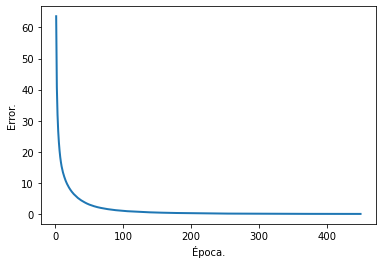

In [16]:
epocas = range(1, len(error_red)+1)
plt.plot(epocas, error_red, lw=2)
plt.xlabel("Época.")
plt.ylabel("Error.")
plt.show()

En la gráfica se aprecia como el error disminuye en gran medida en las primeras 100 épocas.

***

Guardamos el valor de las deltas para un estudio posterior:

In [17]:
import json

nombre_archivo = "deltas_notebook_7.json"

deltas_lista = [[deltas.tolist() for deltas in deltas_x_capa] for deltas_x_capa in deltas]

with open(nombre_archivo, 'w') as f_object:
    json.dump(deltas_lista, f_object) # Deltas contiene 2 arreglos. Las deltas de la capa 1 y las de la capa 2.

Recuperamos el valor de los deltas:

In [80]:
import json

nombre_archivo = r"deltas_notebook_7.json"
with open (nombre_archivo, 'r') as f_object:
    deltas = json.load(f_object)
    
deltas = [np.asarray([deltas for deltas in deltas_x_capa]) for deltas_x_capa in deltas]

***

### **A**  

### Deltas en las neuronas.

In [18]:
print(np.asarray(deltas[0]).shape) # Deltas capa 1.
print(np.asarray(deltas[1]).shape) # Deltas capa 2.

(450000, 40)
(450000, 10)


**<font color="blue">Por cada época nuestras deltas de las capas 1 y 2 sufren 1,000 modificaciones (debido a que ingreamos 1,000 muestras por época), lo que significa que en 450 épocas nuestras deltas de ambas capas sufren 450,000 modificaciones.</font>**

Graficamos todos los errores delta en la capa 1 en una sola gráfica:

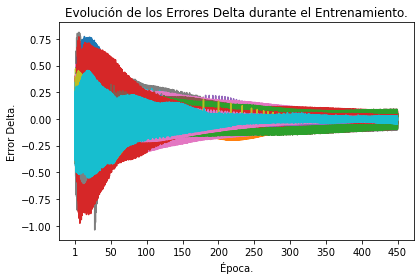

In [99]:
plt.plot(range(1,len(deltas[0])+1), deltas[0])
plt.xticks(range(0,len(deltas[0])+1,50000), [1,50,100,150,200,250,300,350,400,450])
plt.title("Evolución de los Errores Delta durante el Entrenamiento.")
plt.ylabel("Error Delta.")
plt.xlabel("Época.")
plt.tight_layout()
plt.show()

Aunque no se aprecia de manera clara, podemos notar una tendencia de nuestros valores delta para la capa 1 hacia el **0**, lo que es de esperarse debido a que nuestra red general ha reducido en gran medida el error.  

A continuación, graficaremos cada valor delta de manera separada para esta capa, con la finalidad de observar más clara esta tendencia.

Graficamos la evolucion de cada error delta en la capa 1:

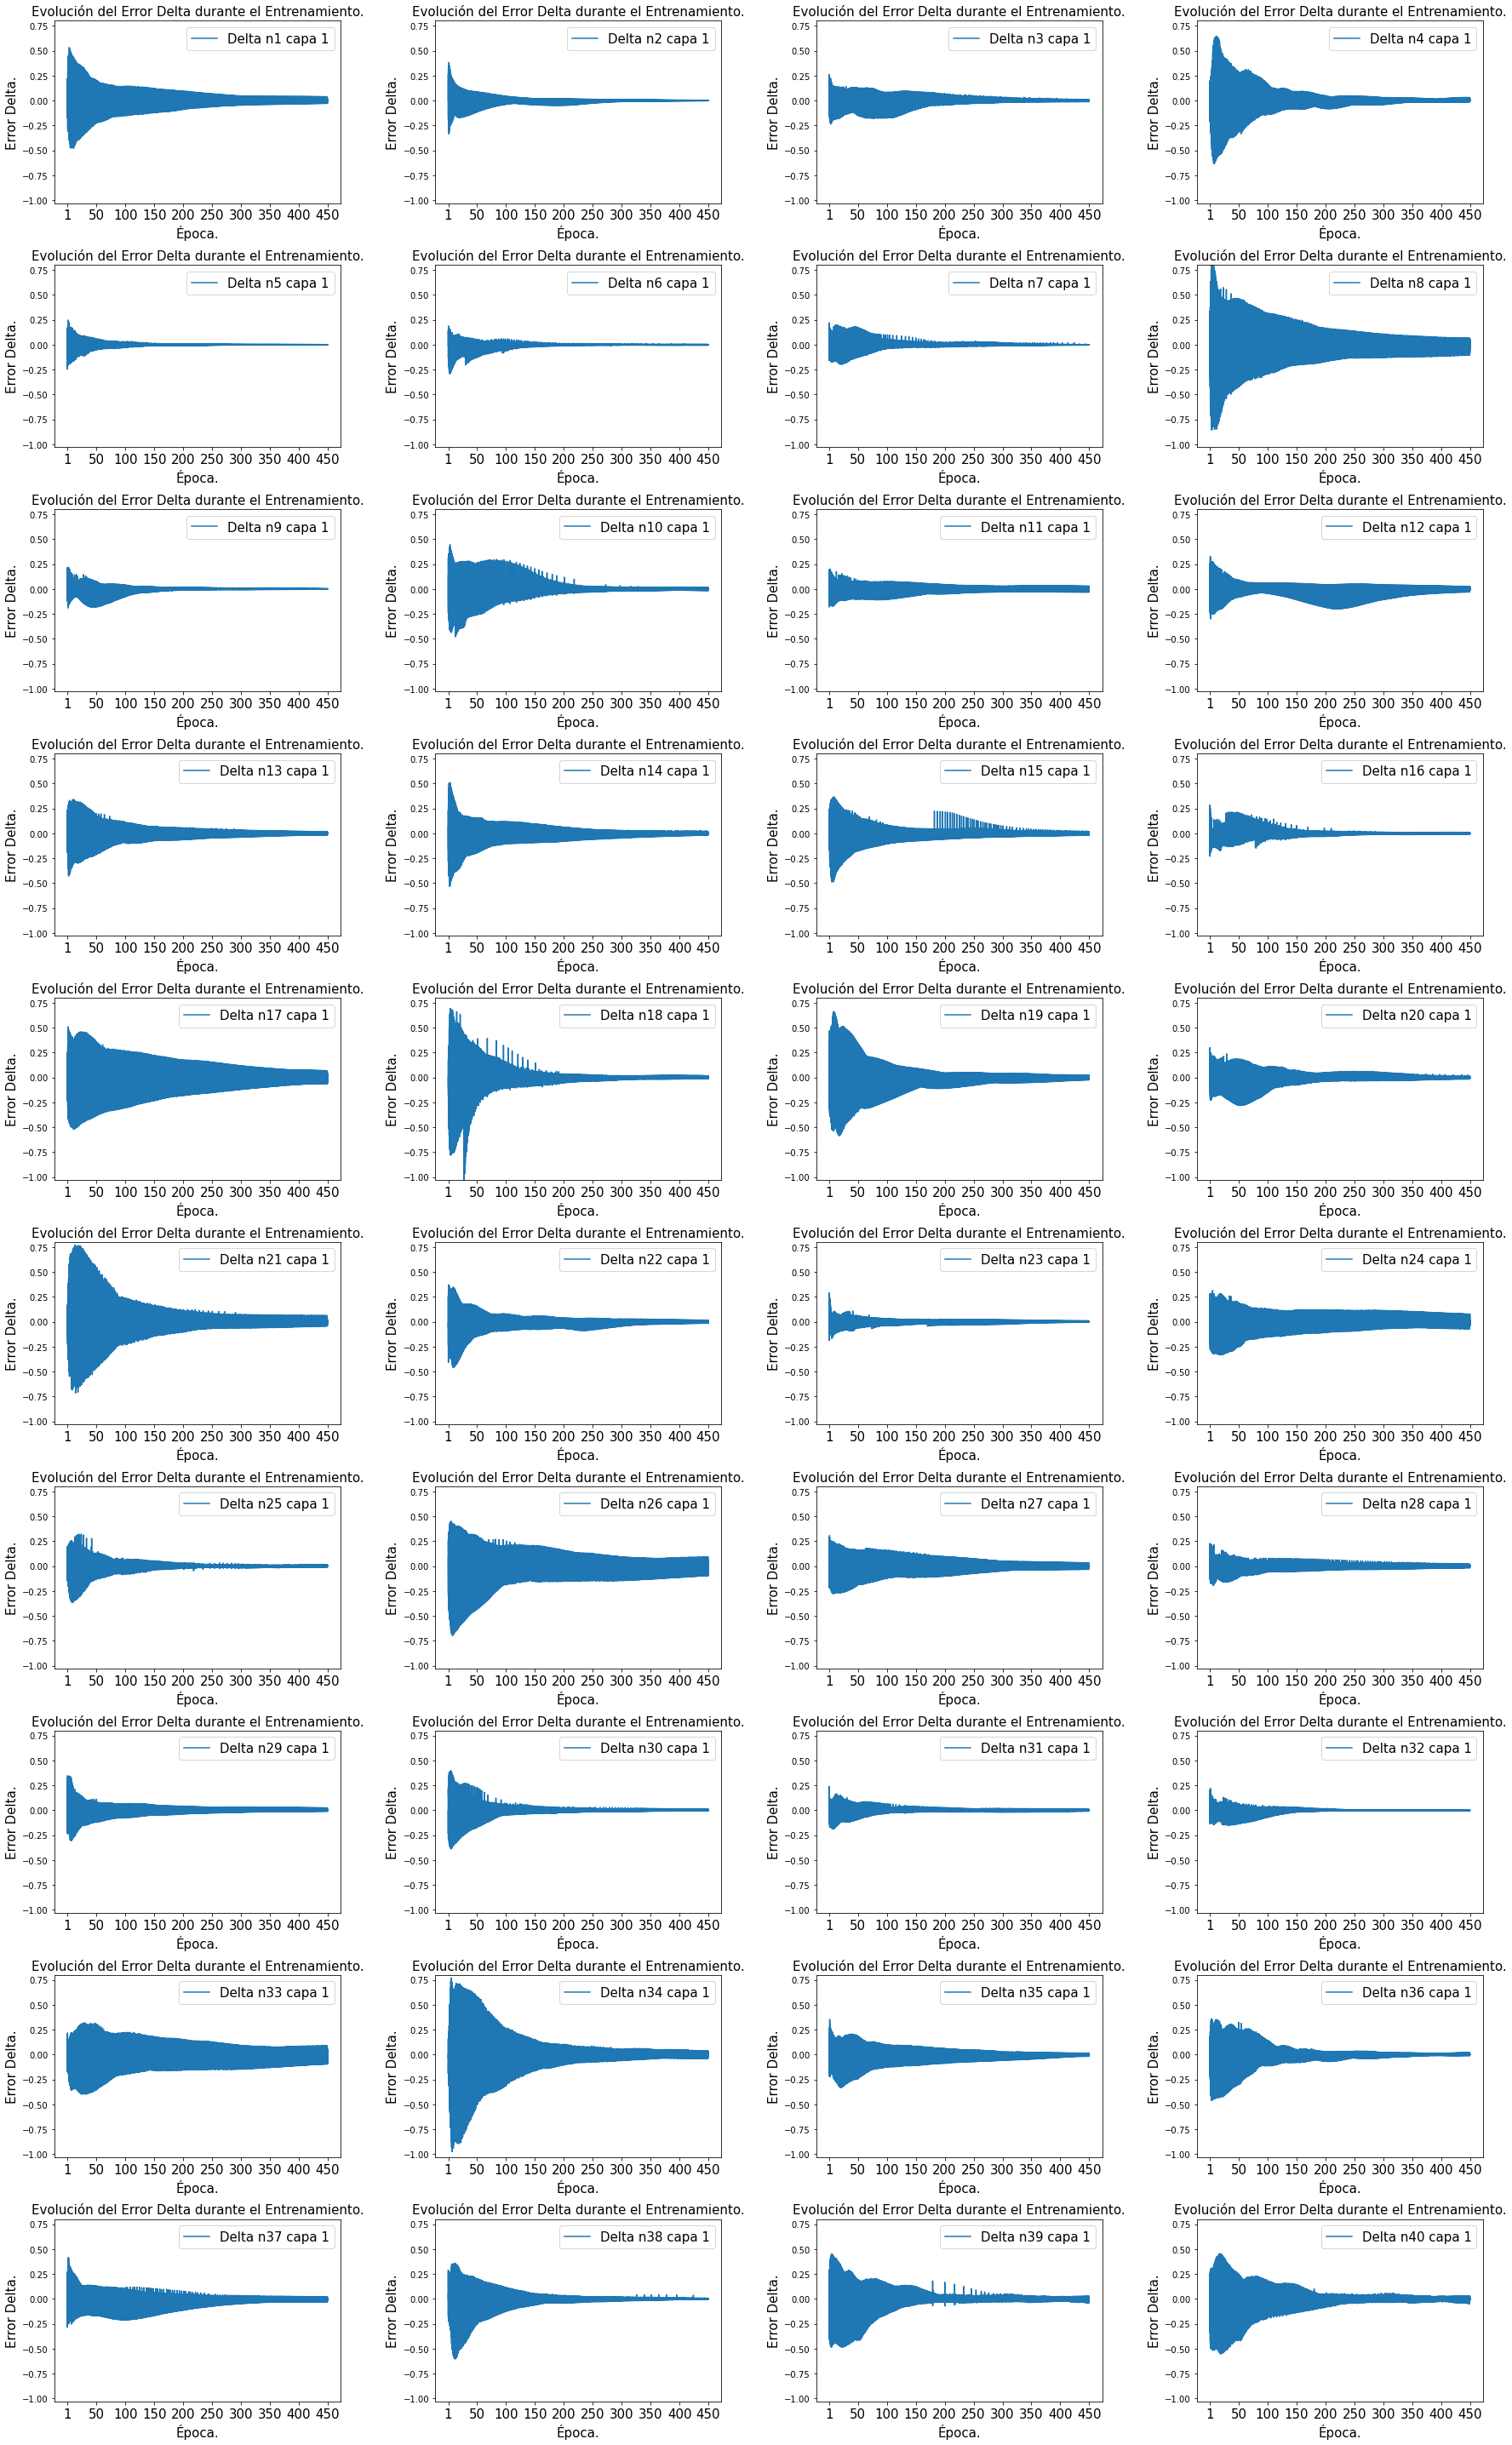

In [101]:
fig, axes = plt.subplots(nrows=10, ncols=4, figsize=(25,40))

index = 0

delta_neurona = ['Delta n'+str(i+1)+" capa 1" for i in range(len(deltas[0][0]))] # Número de neurona (n#).

for i in range(axes.shape[0]):
    
    for j in range(axes.shape[1]):
        
        axes[i,j].plot(range(1,len(np.asarray(deltas[0])[:,index])+1), np.asarray(deltas[0])[:,index], label=delta_neurona[index])
        separacion_etiquetas_ejeX = list(range(0,len(np.asarray(deltas[0])[:,0])+1,50000))
        axes[i,j].set_xticks(separacion_etiquetas_ejeX)
        axes[i,j].set_xticklabels([1,50,100,150,200,250,300,350,400,450], fontsize=15)
        axes[i,j].set_ylim(-1.03, 0.8)
        axes[i,j].set_title("Evolución del Error Delta durante el Entrenamiento.", fontsize=15)
        axes[i,j].set_xlabel("Época.", fontsize=15)
        axes[i,j].set_ylabel("Error Delta.", fontsize=15)
        axes[i,j].legend(fontsize=15)
        
        index += 1
        
plt.tight_layout()
plt.show()

Ahora podemos apreciar de manera mucho más clara la tendencia a **0** que presentan nuestras deltas en las neuronas de la capa 1.

*Es momento de graficar las deltas en la capa 2 (o capa de salida).*  

Comenzaremos graficando la totalidad de deltas para observar la tendencia general que presentan:

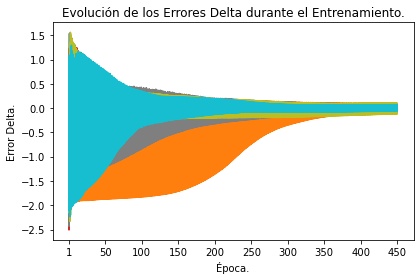

In [98]:
plt.plot(range(1,len(deltas[1])+1), deltas[1])
plt.xticks(range(0,len(deltas[0])+1,50000), [1,50,100,150,200,250,300,350,400,450])
plt.title("Evolución de los Errores Delta durante el Entrenamiento.")
plt.ylabel("Error Delta.")
plt.xlabel("Época.")
plt.tight_layout()
plt.show()

Como es de esperarse, la tendencia es clara, todas las deltas de las neuronas presentes en la capa 2 tienden a **0**.  

Por último, graficaremos cada delta por separado para apreciar la tendencia individual de cada una:

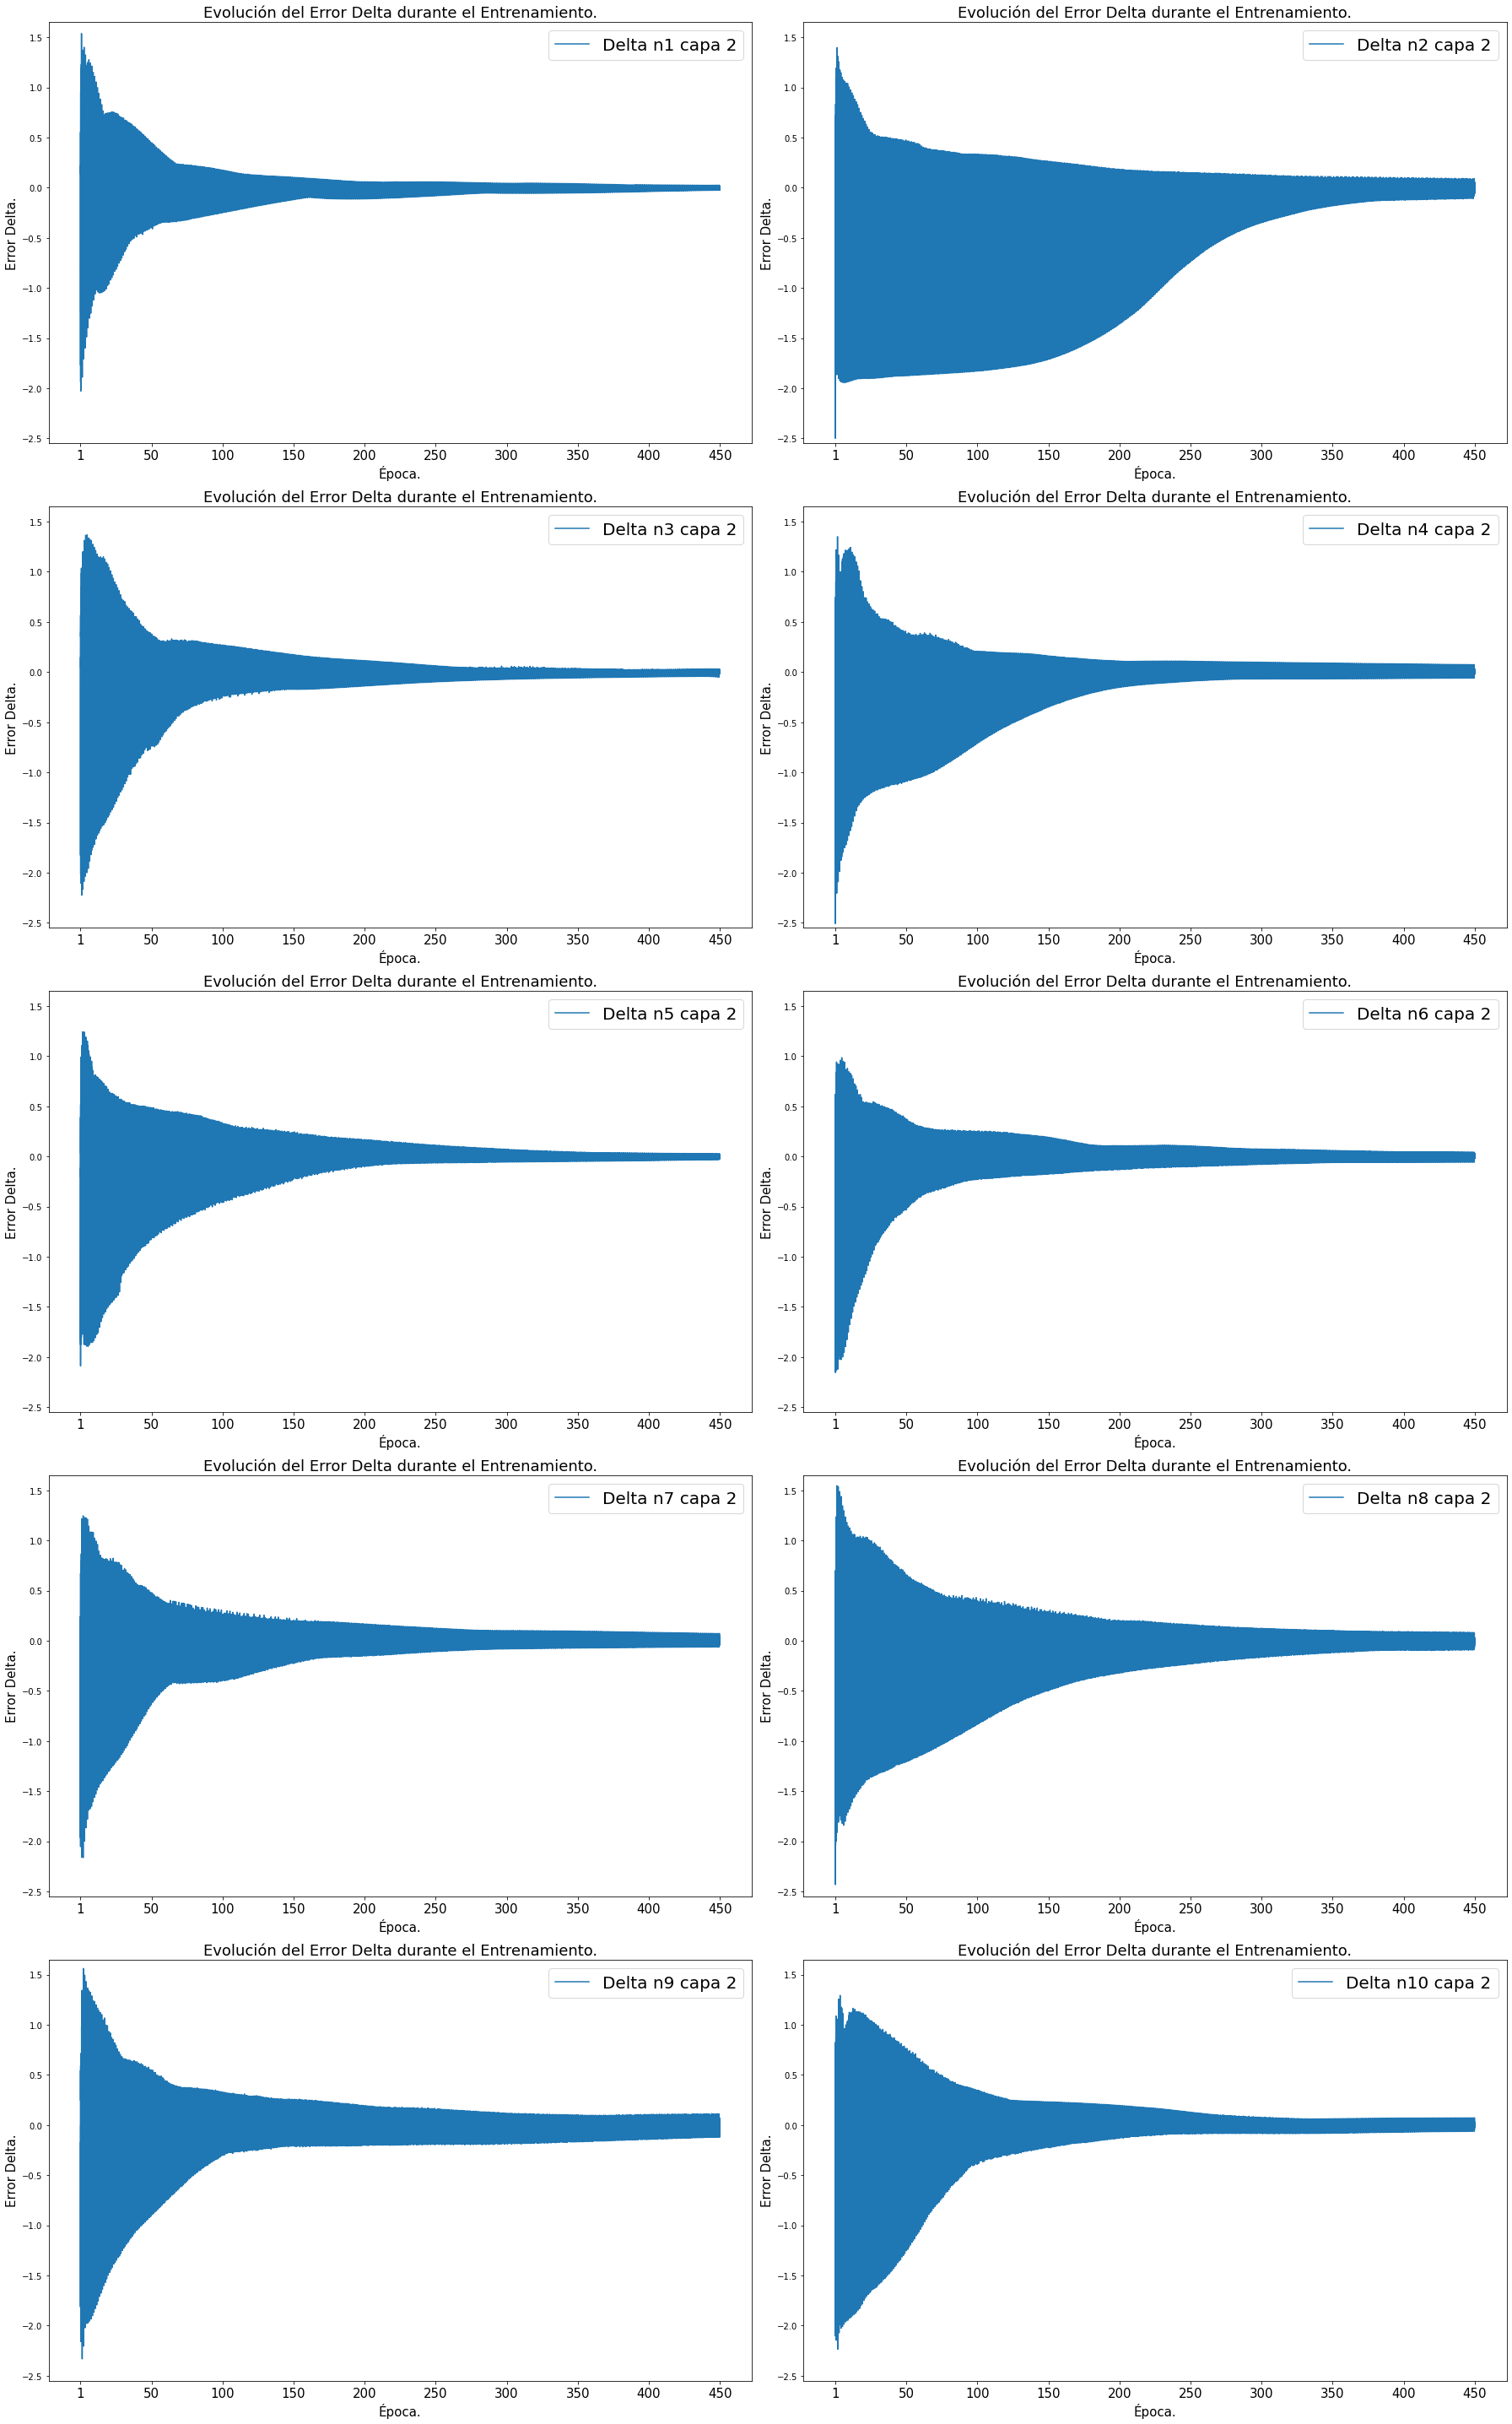

In [103]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(25,40))

index = 0

delta_neurona = ['Delta n'+str(i+1)+" capa 2" for i in range(len(deltas[1][0]))]

for i in range(axes.shape[0]):
    
    for j in range(axes.shape[1]):
        
        axes[i,j].plot(range(1,len(np.asarray(deltas[1])[:,index])+1), np.asarray(deltas[1])[:,index], label=delta_neurona[index])
        separacion_etiquetas_ejeX = list(range(0,len(np.asarray(deltas[1])[:,0])+1,50000))
        axes[i,j].set_xticks(separacion_etiquetas_ejeX)
        axes[i,j].set_xticklabels([1,50,100,150,200,250,300,350,400,450], fontsize=15)
        axes[i,j].set_ylim(-2.55, 1.65)
        axes[i,j].set_title("Evolución del Error Delta durante el Entrenamiento.", fontsize=18)
        axes[i,j].set_xlabel("Época.", fontsize=15)
        axes[i,j].set_ylabel("Error Delta.", fontsize=15)
        axes[i,j].legend(fontsize=20)
        
        index += 1
        
plt.tight_layout()
plt.show()

Al igual que en la capa 1, el error delta de cada neurona en la capa 2, tiende a **0**.

Para plasmar de manera más clara el "por qué" de los patrones previos en las graficas de los errores delta de cada neurona, haremos uso de una red muy sencilla. La arquitectura es la siguiente:  

- 1 neurona de entrada, 1 peso, 1 neurona de salida y la función de error ECM.

In [171]:
import sys

alfa_ = 1.0

entrada_ = np.array([0.5])
salida_deseada_ = np.array([1])
peso_neurona = np.array([0.8])

delta_neurona_ = list()
error_neurona = list()
actualizacion_peso = list()

for iteracion in range(100+1):
    
    prediccion_ = entrada_@peso_neurona
    
    error_ = (prediccion_ - salida_deseada_)**2
    error_neurona.append(error_)
    sys.stdout.write(f"\nError: {error_}")
    
    delta_ = 2*(prediccion_ - salida_deseada_)*1
    delta_neurona_.append(delta_)
    peso_delta = delta_ * entrada_
    
    actualizacion_peso.append(peso_neurona[0])
    peso_neurona -= alfa_ * peso_delta
    
    if prediccion_ == salida_deseada_:
        print(f"\nLa predicción correcta se obtuvo en la época {iteracion+1}\n")
        break


Error: [0.36]
Error: [0.09]
Error: [0.0225]
Error: [0.005625]
Error: [0.00140625]
Error: [0.00035156]
Error: [8.7890625e-05]
Error: [2.19726562e-05]
Error: [5.49316406e-06]
Error: [1.37329102e-06]
Error: [3.43322754e-07]
Error: [8.58306885e-08]
Error: [2.14576721e-08]
Error: [5.36441803e-09]
Error: [1.34110451e-09]
Error: [3.35276127e-10]
Error: [8.38190317e-11]
Error: [2.09547579e-11]
Error: [5.23868948e-12]
Error: [1.30967237e-12]
Error: [3.27418093e-13]
Error: [8.18545232e-14]
Error: [2.04636308e-14]
Error: [5.11590769e-15]
Error: [1.27897692e-15]
Error: [3.19744233e-16]
Error: [7.99360582e-17]
Error: [1.9984014e-17]
Error: [4.99600351e-18]
Error: [1.249001e-18]
Error: [3.1225025e-19]
Error: [7.80625316e-20]
Error: [1.95156329e-20]
Error: [4.87891598e-21]
Error: [1.219729e-21]
Error: [3.0493031e-22]
Error: [7.62325775e-23]
Error: [1.90586291e-23]
Error: [4.76465726e-24]
Error: [1.19104315e-24]
Error: [2.97760787e-25]
Error: [7.44704909e-26]
Error: [1.86176227e-26]
Error: [4.6468344

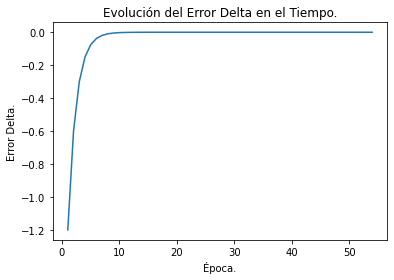

In [194]:
plt.plot(range(1,len(delta_neurona_)+1), delta_neurona_)
plt.title("Evolución del Error Delta en el Tiempo.")
plt.xlabel("Época.")
plt.ylabel("Error Delta.")
plt.show()

In [190]:
print(f"VALOR INICIAL DEL PESO: {actualizacion_peso[0]}")
print(f"VALOR FINAL DEL PESO: {actualizacion_peso[-1]}",'\n')

print(f"PREDICCIÓN REALIZADA CON EL VALOR INICIAL DEL PESO: {entrada_@np.asarray([actualizacion_peso[0]])}")
print(f"PREDICCIÓN REALIZADA CON EL VALOR FINAL DEL PESO: {entrada_@np.asarray([actualizacion_peso[-1]])}",'\n')

print(f"ERROR DELTA DE LA NEURONA CON EL VALOR INICIAL DEL PESO: {delta_neurona_[0]}")
print(f"ERROR DELTA DE LA NEURONA CON EL VALOR FINAL DEL PESO: {delta_neurona_[-1]}")

VALOR INICIAL DEL PESO: 0.8
VALOR FINAL DEL PESO: 2.0 

PREDICCIÓN REALIZADA CON EL VALOR INICIAL DEL PESO: 0.4
PREDICCIÓN REALIZADA CON EL VALOR FINAL DEL PESO: 1.0 

ERROR DELTA DE LA NEURONA CON EL VALOR INICIAL DEL PESO: [-1.2]
ERROR DELTA DE LA NEURONA CON EL VALOR FINAL DEL PESO: [0.]


Se deduce que el valor de nuestra neurona de salida se encuentra de manera inicial por debajo del valor óptimo (para este caso y dado que se trata de una sola neurona, el valor óptimo es la salida deseada),  y esto se comprueba en la gráfica "Evolución del Error Delta en el Tiempo", en donde se observa como el error delta va en aumento hasta hacerse 0, lo que se traduce en una predicción 100% acertada por parte de nuestra red.

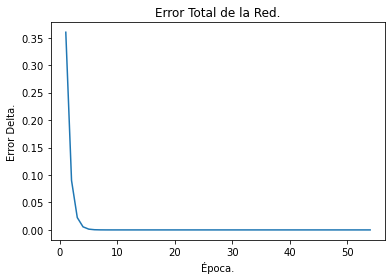

In [193]:
plt.plot(range(1,len(error_neurona)+1), error_neurona)
plt.title("Error Total de la Red.")
plt.xlabel("Época.")
plt.ylabel("Error Delta.")
plt.show()

Como es de esperarse, debido a que sólo contamos con una única neurona en la red, solo existe un sólo error delta, por lo tanto (y para este caso en particular), dado que el error delta es 0, el error total de la red también es 0.  

El error delta de la neurona, así como el error total de la red se aprecian en el código y son los siguientes:

- Error Delta:  $2*(predicción - SalidaDeseada)^2 * 1$  

- Error Total de la Red (ECM para nuestro caso):  $(predicción - SalidaDeseada)^2$  

### **CONCLUSIÓN:**

**<font color="red">El patrón presente en las gráficas confirma el hecho de que el *error delta* en la neurona, notifica en que medida se ha quedado esta por debajo o por arriba de su valor óptimo, es decir, que si el error delta logra llegar a *0*, significa que los pesos pertenecientes a esta neurona habrán generado el patrón que relaciona de manera 100% correcta las entradas con su respectiva neurona de salida. Si lo anterior ocurriera con todas las deltas de la red neuronal, el error total sería 0. Sin embargo, sabemos que siempre (aunque mínimo) existe ruido, por lo que es casi "imposible" que el error total de una red sea 0 en su totalidad, pero sí puede ser un valor muy cercano a este.</font>**

***

### **B**

#### Realizamos inferencia sobre 1,000 datos de prueba y los 1,000 datos tomados para el entrenamiento, con la finalidad de realizar una comparación:

Inferencia sobre los 1,000 datos de entrenamiento:

In [17]:
vector_prediccion_entrenamiento = predicciones(pesos_entrenados, muestras_entrenamiento_1000)
print(vector_prediccion_entrenamiento.shape,'\n')

precision_datos_entrenamiento = ((etiquetas_entrenamiento[:1000] == vector_prediccion_entrenamiento).sum()/len(etiquetas_entrenamiento[:1000]))*100
print(f"La precisión sobre los {imagenes_entrenamiento[:1000].shape[0]} datos de entrenamiento es del {precision_datos_entrenamiento}%")

(1000,) 

La precisión sobre los 1000 datos de entrenamiento es del 100.0%


Inferencia sobre 1,000 datos de prueba:

In [18]:
# Para saber la cantidad y dimension de los datos en el cojunto de prueba o testeo:
print(imagenes_testeo[:1000].shape)
print(etiquetas_testeo_ONE_HOT[:1000].shape)

(1000, 784)
(1000, 10)


In [19]:
vector_de_prediccion = predicciones(pesos_entrenados, imagenes_testeo[:])
print(vector_de_prediccion.shape,'\n')

precision_datos_testeo = ((etiquetas_testeo[:] == vector_de_prediccion).sum()/len(etiquetas_testeo[:]))*100
print(f"La precisión sobre los {imagenes_testeo[:].shape[0]} datos de prueba es del {precision_datos_testeo}%")

(10000,) 

La precisión sobre los 10000 datos de prueba es del 83.19%


**CONCLUSIÓN:**

<font color="red">Dado el porcentage de precisión de nuestra red en los 1,000 datos de entrenamiento, la siguiente pregunta surge: **¿Por qué razón si el porcentaje de precisión de nuestra red sobre los datos de entrenamiento es del **100%**, tenemos un **83.19%** de precisión en el conjunto de datos de prueba?** La respuesta a esta pregunta es la siguiente: **Nuestra red neuronal o modelo resultante tiene OVERFITTING**, es decir, nuestro modelo ha memorizado los datos de entrenamiento, por lo que su capacidad para generelizar en un conjunto de datos nunca antes visto es precaria. Asimismo, la pregunta previa se puede responder desde otro punto de vista y aplica para cualquier red neuronal. Este punto de vista es el de la correlación que existe entre las capas de la red. Una vez la red neuronal haya sido entrenada, los pesos generan patrones basándose en los datos ingresados para el entrenamiento, con la finalidad de relacionar de manera correcta la entrada con su respectiva neurona de salida. Por ejemplo; si nosotros alimentamos nuestra red neuronal ya entrenada, con una muestra que no se relaciona de manera correcta —o presenta una relación mínima— con el patrón establecido por los pesos entre las capas, obtendremos como resultado una predicción errónea y probablemente aleatoria.</font>  

**NOTA:** El argumento de que la falta de elementos en el conjunto de entrenamiento (debido a que sólo utilizamos 1,000), repercute en el porcentage de precisión sobre la totalidad del conjunto de testeo, *NO ES VÁLIDO PARA ESTE PRÓPOSITO*. Lo que se intenta demostrar es que la red ha memorizado la totalidad de las muestras de entrenamiento y es por ello que no tiene capacidad para generalizar adecuadamente en el conjunto de testeo.

***